Experimental setup:
1. split the datasets into two sets - train set (the one on which you train the model) and test set
2. Repeat the training of the CTGAN models
3. Create the bins (the 10 columns) ON THE CLASSIFICATIONS OF THE TRAIN SET
4. For each bin, generate the same number of samples as those of the train set in that bin
5. create two tables like the one you currently create: one  for the samples of the train set in the bin, and one for the test set

In [2]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *
from tqdm import tqdm

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

In [3]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# A. Load data, preprocess, and calculate accuracy 

In [4]:
X, y, le = read_data(dataset)

In [5]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# Split the data to train and test (50% each)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

# B. Plot confidence scores for X_train & X_test

In [7]:
clf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

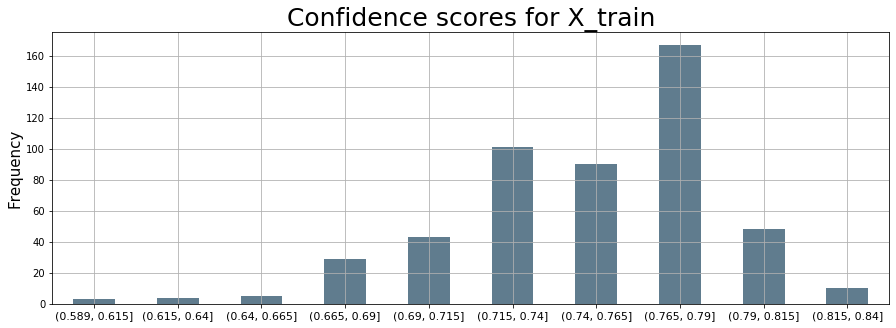

In [8]:
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

In [9]:
clf.fit(X_test, y_test)
y_prob_test = rf.predict_proba(X_test)
y_conf_test = y_prob_test[:, 0]  # confidence scores

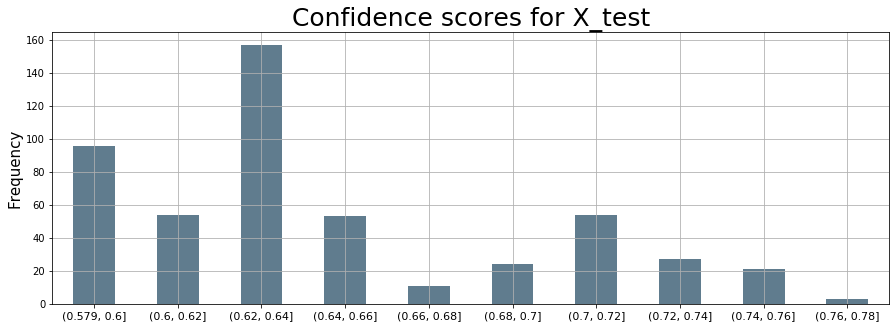

In [10]:
plot_confidence_levels(y_conf_test, "Confidence scores for X_test")

# C. Select C as the middle of top intervals

In [11]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

In [12]:
top_c_lst 

[0.602, 0.6275, 0.6525, 0.6775, 0.7025, 0.7275, 0.7525, 0.7775, 0.8025, 0.8275]

# D. Train 10 CTGANs with middle of intervals

In [13]:
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all 
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)


for c in top_c_lst:
    
    # train CTGAN
    z_features = get_noise_features(X_train, categorical_features)
    z_rows = int(0.25 * X_train.shape[0])
    z = gen_random_noise(shape=(z_rows, z_features))

    batch_size = 50
    epochs = 50
    confidence_level = c
    gen_lr = 2e-5
    loss = 'log'

    
    rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                                blackbox_model=rf,
                                preprocessing_pipeline=preprocessor,
                                bb_loss=loss
                                )

    print(f"Training CTGAN for c = {c}...")
    hist = rf_ctgan.fit(train_data=z,
                        epochs=epochs,
                        confidence_level=confidence_level,
                        gen_lr=gen_lr,
                        verbose=False
                        )

    # rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
    # plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
    # print()
    
    
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    
    
    # ans is the indices of gen_data to make the same dist 
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]
        
    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    gen_data_inv = pd.DataFrame(gen_data_inv)
    
    # y_conf_gen_same_dist, gen_data_inv what we want
    # results
    # E. Calculate coverage for each similarity and conf diff thresholds
    print(f"\tWorking on results...")
    train_results = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)
    test_results = table(gen_data_inv, X_test_pd, y_conf_gen_same_dist, y_conf_test)
    print(f"\tResults for confidence level = {c}")
    display_side_by_side(train_results, test_results)
#     display(train_results)
#     display(test_results)

Training CTGAN for c = 0.602...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.602


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 87.8,100.0 | 89.4,100.0 | 89.6,100.0 | 89.6,100.0 | 89.6
0.85,100.0 | 86.0,100.0 | 86.8,100.0 | 86.8,100.0 | 86.8,100.0 | 86.8
0.90,100.0 | 80.2,100.0 | 83.0,100.0 | 83.2,100.0 | 83.2,100.0 | 83.2
0.95,98.0 | 72.4,100.0 | 79.0,100.0 | 79.0,100.0 | 79.0,100.0 | 79.0
0.99,33.4 | 26.8,84.6 | 53.6,89.0 | 56.6,89.8 | 56.8,89.8 | 56.8
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 84.6,100.0 | 88.4,100.0 | 89.0,100.0 | 89.0,100.0 | 89.2
0.85,100.0 | 81.2,100.0 | 87.0,100.0 | 87.0,100.0 | 87.0,100.0 | 87.0
0.90,100.0 | 76.0,100.0 | 82.4,100.0 | 83.0,100.0 | 83.0,100.0 | 83.2
0.95,93.4 | 59.2,99.8 | 77.0,100.0 | 78.4,100.0 | 78.8,100.0 | 78.8


Training CTGAN for c = 0.6275...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6275


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 90.0,100.0 | 92.4,100.0 | 92.6,100.0 | 93.0,100.0 | 93.0
0.85,100.0 | 86.8,100.0 | 90.6,100.0 | 91.2,100.0 | 91.2,100.0 | 91.4
0.90,100.0 | 82.2,100.0 | 87.6,100.0 | 88.0,100.0 | 88.0,100.0 | 88.0
0.95,96.6 | 71.2,100.0 | 79.8,100.0 | 80.6,100.0 | 80.6,100.0 | 80.6
0.99,28.0 | 26.2,86.8 | 53.4,90.4 | 58.4,90.6 | 59.4,90.6 | 59.4
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 89.2,100.0 | 92.2,100.0 | 92.6,100.0 | 92.6,100.0 | 92.6
0.85,100.0 | 85.6,100.0 | 90.8,100.0 | 91.2,100.0 | 91.2,100.0 | 91.4
0.90,100.0 | 79.0,100.0 | 85.8,100.0 | 87.0,100.0 | 87.4,100.0 | 87.6
0.95,94.0 | 61.8,100.0 | 77.8,100.0 | 79.4,100.0 | 79.8,100.0 | 80.4


Training CTGAN for c = 0.6525...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6525


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 63.4,100.0 | 71.6,100.0 | 73.4,100.0 | 73.4,100.0 | 73.4
0.85,100.0 | 58.2,100.0 | 64.0,100.0 | 65.8,100.0 | 65.8,100.0 | 65.8
0.90,99.4 | 49.6,100.0 | 58.0,100.0 | 60.0,100.0 | 60.0,100.0 | 60.0
0.95,71.2 | 37.6,100.0 | 45.4,100.0 | 47.6,100.0 | 47.6,100.0 | 47.6
0.99,2.8 | 12.4,71.0 | 21.4,76.4 | 24.2,79.0 | 24.4,79.2 | 24.4
,0.01,0.05,0.1,0.15,0.2
0.80,62.2 | 54.8,100.0 | 71.2,100.0 | 73.2,100.0 | 73.4,100.0 | 74.0
0.85,51.6 | 47.8,100.0 | 64.4,100.0 | 65.8,100.0 | 66.4,100.0 | 66.6
0.90,32.4 | 40.4,100.0 | 56.8,100.0 | 59.2,100.0 | 59.4,100.0 | 59.6
0.95,8.0 | 30.0,100.0 | 45.0,100.0 | 46.8,100.0 | 47.8,100.0 | 47.8


Training CTGAN for c = 0.6775...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.6775


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 96.2,100.0 | 97.6,100.0 | 97.6,100.0 | 97.6,100.0 | 97.6
0.85,100.0 | 92.6,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0
0.90,100.0 | 88.4,100.0 | 94.0,100.0 | 94.0,100.0 | 94.2,100.0 | 94.2
0.95,95.6 | 72.2,100.0 | 87.2,100.0 | 87.2,100.0 | 87.2,100.0 | 87.2
0.99,33.2 | 32.0,76.0 | 60.4,82.2 | 61.6,82.4 | 63.0,82.6 | 63.0
,0.01,0.05,0.1,0.15,0.2
0.80,98.4 | 93.2,100.0 | 97.2,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8
0.85,92.0 | 88.0,100.0 | 95.8,100.0 | 96.2,100.0 | 96.2,100.0 | 96.8
0.90,69.2 | 75.0,100.0 | 92.0,100.0 | 93.4,100.0 | 93.4,100.0 | 93.4
0.95,34.8 | 54.4,100.0 | 84.8,100.0 | 86.4,100.0 | 87.6,100.0 | 88.2


Training CTGAN for c = 0.7025...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7025


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 84.6,100.0 | 87.2,100.0 | 87.2,100.0 | 87.2,100.0 | 87.2
0.85,100.0 | 80.4,100.0 | 84.6,100.0 | 85.4,100.0 | 85.4,100.0 | 85.4
0.90,100.0 | 75.4,100.0 | 79.2,100.0 | 79.8,100.0 | 79.8,100.0 | 79.8
0.95,88.4 | 60.6,100.0 | 73.2,100.0 | 73.6,100.0 | 73.6,100.0 | 73.6
0.99,30.2 | 20.8,80.4 | 49.0,85.0 | 50.6,85.6 | 51.2,85.8 | 51.2
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 79.4,100.0 | 87.0,100.0 | 87.2,100.0 | 87.2,100.0 | 87.2
0.85,100.0 | 74.4,100.0 | 84.6,100.0 | 85.2,100.0 | 85.2,100.0 | 85.2
0.90,99.6 | 63.0,100.0 | 78.2,100.0 | 79.0,100.0 | 79.4,100.0 | 79.8
0.95,84.8 | 42.0,100.0 | 68.2,100.0 | 71.0,100.0 | 72.0,100.0 | 74.2


Training CTGAN for c = 0.7275...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7275


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 88.0,100.0 | 89.8,100.0 | 90.6,100.0 | 90.6,100.0 | 90.6
0.85,100.0 | 83.4,100.0 | 87.0,100.0 | 87.2,100.0 | 87.2,100.0 | 87.2
0.90,100.0 | 79.0,100.0 | 82.4,100.0 | 82.8,100.0 | 83.0,100.0 | 83.0
0.95,100.0 | 70.6,100.0 | 76.0,100.0 | 76.4,100.0 | 76.4,100.0 | 76.4
0.99,42.6 | 28.4,90.0 | 51.8,92.6 | 56.4,93.0 | 56.4,93.2 | 56.4
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 81.6,100.0 | 89.0,100.0 | 90.2,100.0 | 90.4,100.0 | 90.4
0.85,99.8 | 78.6,100.0 | 85.4,100.0 | 87.2,100.0 | 87.4,100.0 | 87.4
0.90,98.0 | 72.2,100.0 | 80.8,100.0 | 82.6,100.0 | 82.6,100.0 | 82.6
0.95,70.6 | 61.4,100.0 | 74.2,100.0 | 76.0,100.0 | 76.2,100.0 | 76.4


Training CTGAN for c = 0.7525...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7525


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 85.8,100.0 | 88.0,100.0 | 88.0,100.0 | 88.2,100.0 | 88.2
0.85,100.0 | 82.0,100.0 | 84.0,100.0 | 84.0,100.0 | 84.4,100.0 | 84.4
0.90,100.0 | 77.0,100.0 | 79.6,100.0 | 79.6,100.0 | 79.8,100.0 | 79.8
0.95,92.8 | 62.2,100.0 | 70.6,100.0 | 71.6,100.0 | 71.8,100.0 | 71.8
0.99,16.0 | 21.6,84.6 | 40.8,88.8 | 43.4,89.4 | 43.8,89.4 | 43.8
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 83.8,100.0 | 87.4,100.0 | 87.8,100.0 | 88.2,100.0 | 88.6
0.85,100.0 | 77.8,100.0 | 83.2,100.0 | 83.2,100.0 | 83.4,100.0 | 84.0
0.90,99.4 | 66.4,100.0 | 79.4,100.0 | 80.0,100.0 | 80.0,100.0 | 80.0
0.95,72.8 | 46.6,99.8 | 67.2,100.0 | 69.2,100.0 | 70.6,100.0 | 72.0


Training CTGAN for c = 0.7775...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.7775


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 95.8,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0
0.85,100.0 | 93.4,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0
0.90,100.0 | 88.8,100.0 | 93.6,100.0 | 93.8,100.0 | 93.8,100.0 | 93.8
0.95,95.4 | 79.8,100.0 | 87.6,100.0 | 88.0,100.0 | 88.2,100.0 | 88.2
0.99,38.4 | 35.2,88.2 | 65.0,92.2 | 69.4,92.8 | 70.2,92.8 | 70.2
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 93.8,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0
0.85,100.0 | 91.2,100.0 | 95.6,100.0 | 96.2,100.0 | 96.2,100.0 | 96.2
0.90,100.0 | 85.4,100.0 | 92.4,100.0 | 93.4,100.0 | 94.0,100.0 | 94.2
0.95,97.4 | 71.4,100.0 | 85.8,100.0 | 86.8,100.0 | 87.8,100.0 | 87.8


Training CTGAN for c = 0.8025...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.8025


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 98.0,100.0 | 99.2,100.0 | 99.4,100.0 | 99.4,100.0 | 99.4
0.85,100.0 | 96.2,100.0 | 97.6,100.0 | 98.2,100.0 | 98.2,100.0 | 98.2
0.90,100.0 | 93.6,100.0 | 95.6,100.0 | 96.2,100.0 | 96.2,100.0 | 96.2
0.95,99.2 | 87.6,100.0 | 92.0,100.0 | 92.8,100.0 | 92.8,100.0 | 92.8
0.99,34.4 | 40.2,83.0 | 77.2,88.0 | 79.4,88.0 | 80.4,88.0 | 80.4
,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 97.6,100.0 | 99.2,100.0 | 99.2,100.0 | 99.2,100.0 | 99.4
0.85,100.0 | 95.6,100.0 | 98.0,100.0 | 98.0,100.0 | 98.4,100.0 | 98.4
0.90,98.8 | 91.8,100.0 | 95.2,100.0 | 95.2,100.0 | 95.6,100.0 | 96.2
0.95,70.4 | 68.0,100.0 | 91.8,100.0 | 91.8,100.0 | 92.8,100.0 | 93.0


Training CTGAN for c = 0.8275...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.8275


,0.01,0.05,0.1,0.15,0.2
0.80,100.0 | 81.4,100.0 | 83.6,100.0 | 83.6,100.0 | 83.6,100.0 | 83.6
0.85,100.0 | 77.0,100.0 | 79.4,100.0 | 79.6,100.0 | 79.6,100.0 | 79.6
0.90,100.0 | 72.2,100.0 | 74.0,100.0 | 75.0,100.0 | 75.0,100.0 | 75.0
0.95,100.0 | 63.6,100.0 | 69.6,100.0 | 70.8,100.0 | 70.8,100.0 | 70.8
0.99,52.0 | 26.0,88.0 | 43.2,91.2 | 46.4,91.4 | 46.4,91.6 | 46.4
,0.01,0.05,0.1,0.15,0.2
0.80,98.6 | 75.2,100.0 | 83.2,100.0 | 83.8,100.0 | 84.0,100.0 | 84.0
0.85,90.8 | 69.2,100.0 | 78.6,100.0 | 79.8,100.0 | 80.0,100.0 | 80.2
0.90,66.2 | 57.4,100.0 | 74.0,100.0 | 74.4,100.0 | 74.4,100.0 | 74.8
0.95,22.2 | 40.2,100.0 | 68.0,100.0 | 69.0,100.0 | 69.2,100.0 | 69.6
